# Kaggle Comp - Classical Music Meets Classical ML

## Assignment 

- https://www.kaggle.com/competitions/classical-music-meets-clasical-ml-spring-2025/data

### Data
- Our task is to build a model to predict which previous patrons will purchase
a subscription to the 2014-15 concert season
- We are given a subset of patrons along with a 0/1 label indicating whether they
purchased a 2014-15 season subscription (train.csv)
- We are given a test set containing accounts to generate predictions (test.csv)
- We are also given several other datafiles:
    - Account.csv: location info for each patron and donation history
    - Tickets_all.csv: previously purchased tickets by account - season, location, set, price level, # seats
    - Subscriptions.csv: previously purchased subscriptions by account – season, location, price level, # seats
    - Concerts.csv: previous concerts by season – title, composer, location
    - Concerts_2014-15.csv: list of planned 2014-15 sets
    - zipcodes.csv: information about zip codes

### Approach
- Determine possible features
- Create a data pipeline to build features (both train and test)
    - Clean data
    - Generate features
    - Prepare data for modeling
- Perform modeling (validation approach) 
    - Feature engineering & selection
    - Evaluate algorithms
    - Tune hyperparameters
    - Possibly create ensembles

### Scoring
- We will use AUROC to score your probabilistic predictions
  - Kaggle will automatically calculate it for you when you upload your predictions
- Test set is divided into public and private test sets
- Public leaderboard will show your performance on the public test set
- Your final leaderboard position will depend on the private test set
    - This prevents any attempt to “game the system”
- Your grade will be calculated based on your private test set performance
- Your grade will depend on three parts:
    – Your score on the private test set (70 points)
    – Your code hygiene (10 points)
        - All submission code must be in python scripts (no notebooks)
        - Code should be organized (functions & classes), no loose code
        - Code should be easy to follow and reasonably documented (docstrings for
functions and classes)
    - Your writeup of your modeling process (20 points)
        - README doc describing your data pipeline and modeling approach
        - Must be understandable and sufficiently detailed

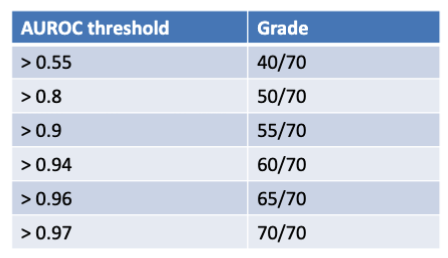

## Data

In [1]:
!ls ../data

account.csv           sample_submission.csv tickets_all.csv
concerts.csv          subscriptions.csv     train.csv
concerts_2014-15.csv  test.csv              zipcodes.csv


In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

### Train Set

In [4]:
# Subset of accounts/patrons and whether they purchased a 2014-2015 subscription
train_df = pd.read_csv('../data/train.csv')
train_df.head() 

,account.id,label
0,001i000000NuRo3,0
1,001i000000NuRxd,0
2,001i000000NuQGN,0
3,001i000000NuPfL,0
4,001i000000NuQkP,0


In [5]:
train_df[train_df['label']==1].count()

account.id    332
label         332
dtype: int64

In [6]:
# Super imbalanced classes here...

### Predict Set

In [7]:
# Test set containing accounts to generate predictions for 
test_df = pd.read_csv('../data/test.csv') 
test_df.head()

,ID
0,001i000000NuQ6Y
1,001i000000NuQXz
2,001i000000NuRDC
3,001i000000NuQeg
4,001i000000NuOQc


### Patron location and donation history

In [8]:
# Presence of 0xc3 character suggests account.csv is encoded with ISO-8859-2
account_df = pd.read_csv('../data/account.csv', encoding='ISO-8859-2')
account_df

,account.id,shipping.zip.code,billing.zip.code,shipping.city,billing.city,relationship,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,first.donated
0,001i000000LhSrQ,94102,94102,San Francisco,San Francisco,NaN,0.0,0.0,0,NaN
1,001i000000LhyPD,NaN,94303,NaN,Palo Alto,NaN,0.0,500.0,5,1987-07-04 00:00:00
2,001i000000LhyPE,NaN,94597,NaN,Walnut Creek,NaN,0.0,783.0,7,2008-06-02 00:00:00
3,001i000000LhyPF,NaN,94610,NaN,Oakland,NaN,1500.0,28435.0,28,1986-07-04 00:00:00
4,001i000000LhyPG,NaN,94024,NaN,Los Altos,NaN,300.0,4969.0,16,1997-04-07 00:00:00
...,...,...,...,...,...,...,...,...,...,...
19828,001i0000018BZTP,NaN,95014,NaN,Cupertino,NaN,0.0,0.0,0,NaN
19829,001i0000018BZTt,NaN,94521,NaN,Concord,NaN,0.0,0.0,0,NaN
19830,001i0000018BZUN,NaN,94552,NaN,castro valley,NaN,0.0,0.0,0,NaN
19831,001i0000018BZUr,NaN,94043,NaN,Mountain view,NaN,0.0,0.0,0,NaN


### Previous year's ticket purchases

In [9]:
tickets_df = pd.read_csv('../data/tickets_all.csv') 
tickets_df.head()

,account.id,price.level,no.seats,marketing.source,season,location,set,multiple.tickets
0,001i000000NuOP0,4,2,NaN,2012-2013,San Francisco,4.0,no
1,001i000000NuOYU,1,1,Other,2013-2014,Berkeley Sunday,6.0,no
2,001i000000NuRS9,4,2,NaN,2011-2012,Family concert,3.0,no
3,001i000000NuRPj,3,1,Postcard or brochure,2013-2014,Berkeley Saturday,2.0,no
4,001i000000NuRQ1,2,2,NaN,2013-2014,Berkeley Saturday,1.0,no


### Previous subscriptions by account 

In [10]:
subs_df = pd.read_csv('../data/Subscriptions.csv') 
subs_df.head() 

,account.id,season,package,no.seats,location,section,price.level,subscription_tier,multiple.subs
0,001i000000LhyR3,2009-2010,Quartet,2,San Francisco,Premium Orchestra,1.0,1.0,no
1,001i000000NuOeY,2000-2001,Full,2,San Francisco,Orchestra,2.0,2.0,no
2,001i000000NuNvb,2001-2002,Full,2,Berkeley Saturday,Balcony Front,3.0,2.0,no
3,001i000000NuOIz,1993-1994,Quartet,1,Contra Costa,Orchestra,2.0,0.5,no
4,001i000000NuNVE,1998-1999,Full,2,Berkeley Sunday,Balcony Rear,4.0,2.0,no


### Concerts by season

In [11]:
concerts_df = pd.read_csv('../data/Concerts.csv') 
concerts_df.head() 

,season,concert.name,set,who,what,location
0,2010-2011,Robert Levin Plays Mozart,1,"Nicholas McGegan, conductor\rRobert Levin, for...","MOZART: Incidental Music from Thamos, King of ...",Peninsula
1,2010-2011,Robert Levin Plays Mozart,1,"Nicholas McGegan, conductor\rRobert Levin, for...","MOZART: Incidental Music from Thamos, King of ...",Berkeley Sunday
2,2010-2011,Robert Levin Plays Mozart,1,"Nicholas McGegan, conductor\rRobert Levin, for...","MOZART: Incidental Music from Thamos, King of ...",San Francisco
3,2010-2011,Robert Levin Plays Mozart,1,"Nicholas McGegan, conductor\rRobert Levin, for...","MOZART: Incidental Music from Thamos, King of ...",Berkeley Saturday
4,2010-2011,Robert Levin Plays Mozart,1,"Nicholas McGegan, conductor\rRobert Levin, for...","MOZART: Incidental Music from Thamos, King of ...",Contra Costa


In [44]:
# ❗️ The who and what columns at least contain multiple newline-separated entries, make sure this gets parsed if we suspect the info has predictive value

In [42]:
concerts_df.iloc[0][4]

/var/folders/rj/1f5wy6qj5r317rr06jymfqth0000gn/T/ipykernel_18675/1539653769.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  concerts_df.iloc[0][4]


"MOZART: Incidental Music from Thamos, King of Egypt, K. 345\rMOZART: Concerto for Fortepiano No. 20 in D minor, K. 466\rLEVIN: Improvisations on themes submitted by the audience\rMOZART/LEVIN: Concerto Movement in G major from Nannerl's Music\rBook, NMA No. 51 (newly attributed to Mozart, US Premiere)\rLEVIN: Variations on themes submitted by the audience\rMOZART:Symphony No. 41 in C major, K. 551 Jupiter\x9d"

### Planned concerts for this season (2014-2015) 

In [12]:
upcoming_df = pd.read_csv('../data/Concerts_2014-15.csv') 
upcoming_df.head()

,season,concert.name,set,who,what
0,2014-2015,"Steven Isserlis, Boccherini, and Haydn",1,"Nicholas McGegan, conductor, Steven Isserlis, ...",BOCCHERINIConcerto for Violoncello No. 7 in G ...
1,2014-2015,"Andreas Scholl, J.S. Bach, and Handel",2,"Julian Wachner, conductor, Andreas Scholl, cou...",HANDELArias including ÒVa tacitoÓ from Giulio ...
2,2014-2015,Vivaldi and Zelenka: A Joyous Christmas,3,"Nicholas McGegan, conductor, Dominique Labelle...","VIVALDI Dixit Dominus, RV 807 ZELENKA Missa Na..."
3,2014-2015,The Cousins Bach,4,"Nicholas McGegan, conductor Sherezade Panthaki...","Johann Ludwig BACH, Trauermusik, Johann Christ..."
4,2014-2015,Rachel Podger and Vivaldi,5,"Rachel Podger, violin and leader",VIVALDI Violin concertos from LÕestro armonico...


### Zip code reference

In [13]:
zip_df = pd.read_csv('../data/zipcodes.csv') 
zip_df.head()

,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,705,STANDARD,AIBONITO,PR,PRIMARY,18.14,-66.26,NA-US-PR-AIBONITO,False,NaN,NaN,NaN
1,610,STANDARD,ANASCO,PR,PRIMARY,18.28,-67.14,NA-US-PR-ANASCO,False,NaN,NaN,NaN
2,611,PO BOX,ANGELES,PR,PRIMARY,18.28,-66.79,NA-US-PR-ANGELES,False,NaN,NaN,NaN
3,612,STANDARD,ARECIBO,PR,PRIMARY,18.45,-66.73,NA-US-PR-ARECIBO,False,NaN,NaN,NaN
4,601,STANDARD,ADJUNTAS,PR,PRIMARY,18.16,-66.72,NA-US-PR-ADJUNTAS,False,NaN,NaN,NaN
